<a href="https://colab.research.google.com/github/SeulGiPark-KISTI/-study/blob/main/08_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Chapter 8 – Dimensionality Reduction**

_This notebook contains all the sample code and solutions to the exercises in chapter 8._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/08_dimensionality_reduction.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA
Let's build a simple 3D dataset:

In [2]:
# PCA 예제를 위한 3차원 synthetic 데이터 생성

np.random.seed(4)
m = 60                # 샘플 개수
w1, w2 = 0.1, 0.3     # 세 번째 축(X3)의 선형 조합 계수
noise = 0.1           # 노이즈 세기

# 1. 각 샘플에 대해 랜덤한 각도 생성 (비선형 구조 유도)
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5      # 범위: [-0.5, (3π/2 - 0.5)]

# 2. 빈 배열 생성 후 각 차원(X1, X2, X3)에 값 할당
X = np.empty((m, 3))    # shape: (60, 3)
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2    # X1: 원형 구조 + 노이즈
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2   # X2: 원형 구조를 0.7배 축소 + 노이즈
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)    # X3: X1, X2의 선형 조합 + 노이즈 (사실상 2D 평면 위에 약간 떠 있는 데이터)

## Principal Components

In [3]:
# PCA 주성분 추출: SVD 기반

X_centered = X - X.mean(axis=0)       # 1. 데이터 중심화 (평균이 0이 되도록 이동)
U, s, Vt = np.linalg.svd(X_centered)  # 2. SVD 분해: X_centered = U * Σ * Vt

# 3. 주성분 추출 (Vt의 행은 주축 / Vt.T의 열은 주성분 벡터)
c1 = Vt.T[:, 0]                       # 제1 주성분 벡터 (최대 분산 방향)
c2 = Vt.T[:, 1]                       # 제2 주성분 벡터 (그 다음 분산 방향)

In [4]:
m, n = X.shape    # m: 샘플 수, n: 특성 수 (예: 60 x 3)

# 특이값 행렬 S (m x n 크기의 0으로 초기화된 행렬 생성)
S = np.zeros(X_centered.shape)    # s는 특이값 벡터 (길이 n), shape: (60, 3)
S[:n, :n] = np.diag(s)            # 상위 n개의 특이값을 대각 성분으로 배치 -> Σ 행렬 구성 (SVD에서 중앙 대각 행렬)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))  # True: X_centered ≈ U @ S @ Vᵀ라는 것. 즉, SVD가 성공적으로 이루어졌고, 정확한 복원이 가능

True

## Projecting Down to d Dimensions

In [9]:
W2 = Vt.T[:, :2]          # 주성분 축 선택: Vt.T의 앞 2개 열 벡터 → 주성분 1, 2, shape: (n_features, n_components) = (3, 2)
X2D = X_centered.dot(W2)  # 데이터 투영: 중심화된 X 데이터를 W2 방향으로 선형 투영, shape: (n_samples, 2)

In [10]:
X2D_using_svd = X2D       # 3D → 2D 로 차원 축소된 데이터

## Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)     # PCA 객체 생성: 주성분 2개만 추출 (2D 투영용)
X2D = pca.fit_transform(X)    # X 데이터를 PCA 축으로 변환 (fit + transform 결합), shape: (60, 2) → 2차원 주성분 공간으로 투영된 결과

In [12]:
X2D[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [13]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [14]:
np.allclose(X2D, -X2D_using_svd)   # Scikit-learn의 PCA는 내부적으로 explained_variance_의 크기 순서대로 주성분을 정렬.
#반면, 수작업 SVD에서는 직접 Vt.T[:, :2]를 사용하므로 주성분 축의 방향 또는 순서가 다를 수 있음.

False

Recover the 3D points projected on the plane (PCA 2D subspace).

In [15]:
X3D_inv = pca.inverse_transform(X2D)

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [16]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [17]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1)) # PCA로 3D → 2D → 3D로 복원한 데이터(X3D_inv)가 원본 데이터(X)와 얼마나 다른지를 측정

np.float64(0.01017033779284855)

The inverse transform in the SVD approach looks like this:

In [21]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])    # SVD 기반 PCA 결과를 이용해 2D → 3D 복원

The reconstructions from both methods are not identical because Scikit-Learn's `PCA` class automatically takes care of reversing the mean centering, but if we subtract the mean, we get the same reconstruction:

In [19]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)   # SVD 기반 PCA 구현이 sklearn.PCA와 기하학적으로 동일하게 작동

True

The `PCA` object gives access to the principal components that it computed:

In [22]:
pca.components_

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Compare to the first two principal components computed using the SVD method:

In [23]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Notice how the axes are flipped.

## Explained Variance Ratio

Now let's look at the explained variance ratio:

In [24]:
pca.explained_variance_ratio_   # 주성분	분산 비율

array([0.84248607, 0.14631839])

The first dimension explains 84.2% of the variance, while the second explains 14.6%.

By projecting down to 2D, we lost about 1.1% of the variance:

In [ ]:
1 - pca.explained_variance_ratio_.sum()   #약 1.12%의 분산 정보가 손실, 손실이 거의 없음

0.011195535570688975

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [25]:
np.square(s) / np.square(s).sum()     #SVD 기반 PCA에서 설명된 분산 비율 (Explained Variance Ratio) 를 직접 계산한 것으로, Scikit-Learn의 PCA.explained_variance_ratio_와 수학적으로 동일한 결과

array([0.84248607, 0.14631839, 0.01119554])

Next, let's generate some nice figures! :)

**Code to generate Figure 8–2. A 3D dataset lying close to a 2D subspace:**

Utility class to draw 3D arrows (copied from http://stackoverflow.com/questions/11140163)

In [33]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

# 사용자 정의 클래스: 3D 화살표를 3D 플롯에 그릴 수 있게 해주는 도구, FancyArrowPatch(2D용)를 확장하여 3D 좌표 지원을 추가함
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

Express the plane as a function of x and y.

In [34]:
# PCA 투영 평면의 Z 좌표를 계산
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]    # 시각화 영역 설정: x, y, z 좌표 축의 제한 범위

x1s = np.linspace(axes[0], axes[1], 10)     # x1 (가로축), x2 (세로축) 범위 설정 및 격자 생성 → PCA 평면 상의 격자 점을 만들기 위한 x-y 좌표
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)              # shape: (10, 10)

C = pca.components_                         # PCA 주성분 행렬 가져오기, C.shape = (2, 3): 2개의 주성분, 각 주성분은 3차원 벡터
R = C.T.dot(C)                              # R = Cᵀ × C: 투영 평면 상의 항등 변환 성분 추출, 3x3 행렬, projection matrix
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])   # Z 좌표 계산: PCA 주평면 위에 놓이는 z(x, y), (x1, x2)가 평면상에 있다고 가정하고 PCA 투영 공식에 따라 z를 유도

Plot the 3D dataset, the plane and the projections on that plane.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))          # 3D 시각화 캔버스 생성
ax = fig.add_subplot(111, projection='3d')

# 원본 데이터 중 PCA 투영 평면 위보다 위/아래에 있는 점을 구분
X3D_above = X[X[:, 2] > X3D_inv[:, 2]]      # 평면 위보다 위에 있는 점
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]     # 평면 아래에 있는 점

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)   # 아래에 있는 점 먼저 시각화 (파란색 원)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")    # PCA 평면 그리기
np.linalg.norm(C, axis=0)

# 주성분 방향 (components_)을 3D 화살표로 시각화
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")    # 원점 표시

# 원본 데이터 → 투영된 점을 선으로 연결, 위쪽 점은 진한 회색, 아래쪽 점은 검정
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")

# 투영된 점 (검정 벡 + 점)
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# (버그 회피용 주석) matplotlib 3.0.0의 3D 표시 문제 관련 참고사항
# Note: If you are using Matplotlib 3.0.0, it has a bug and does not
# display 3D graphs properly.
# See https://github.com/matplotlib/matplotlib/issues/12239
# You should upgrade to a later version. If you cannot, then you can
# use the following workaround before displaying each 3D graph:
# for spine in ax.spines.values():
#     spine.set_visible(False)

save_fig("dataset_3d_plot")
plt.show()

**Code to generate Figure 8–3. The new 2D dataset after projection:**

Saving figure dataset_2d_plot


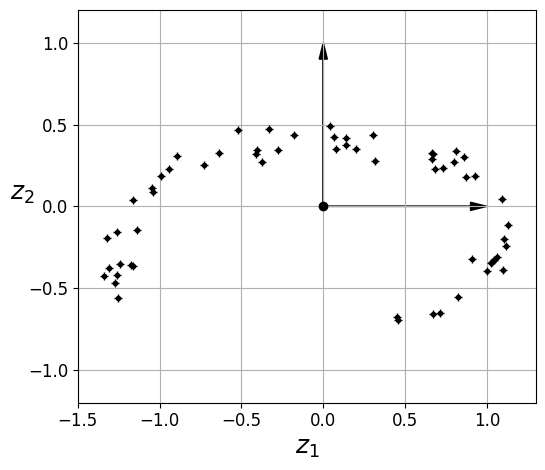

In [37]:
fig = plt.figure()                          # 2D 평면 (주성분 공간)에서 투영된 데이터 시각화
ax = fig.add_subplot(111, aspect='equal')   # 정사각 격자 비율 유지

# PCA 투영된 점들을 +와 .로 시각화 (검정색)
ax.plot(X2D[:, 0], X2D[:, 1], "k+")         # 십자 마커
ax.plot(X2D[:, 0], X2D[:, 1], "k.")         # 점 마커
ax.plot([0], [0], "ko")                     # 원점 표시

# 축 화살표: z1 방향 (위), z2 방향 (오른쪽)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')   # z1 축 (y축)
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')   # z2 축 (x축)
ax.set_xlabel("$z_1$", fontsize=18)   # 제1 주성분
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)    # 제2 주성분
ax.axis([-1.5, 1.3, -1.2, 1.2])   # 축 범위 설정
ax.grid(True)   # 격자 표시
save_fig("dataset_2d_plot")

**Code to generate Figure 8–4. Swiss roll dataset:**

In [38]:
from sklearn.datasets import make_swiss_roll
# 비선형 고차원 매니폴드 데이터 생성 (스위스 롤 데이터셋)
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


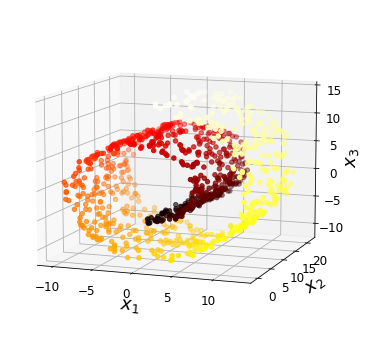

In [ ]:
axes = [-11.5, 14, -2, 23, -12, 15]   # [x_min, x_max, y_min, y_max, z_min, z_max]

fig = plt.figure(figsize=(6, 5))      # 3D 시각화 초기화
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)   # 스위스 롤 데이터 시각화 (1000개 점, 색상: 롤 위치 t)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

**Code to generate Figure 8–5. Squashing by projecting onto a plane (left) versus unrolling the Swiss roll (right):**

Saving figure squished_swiss_roll_plot


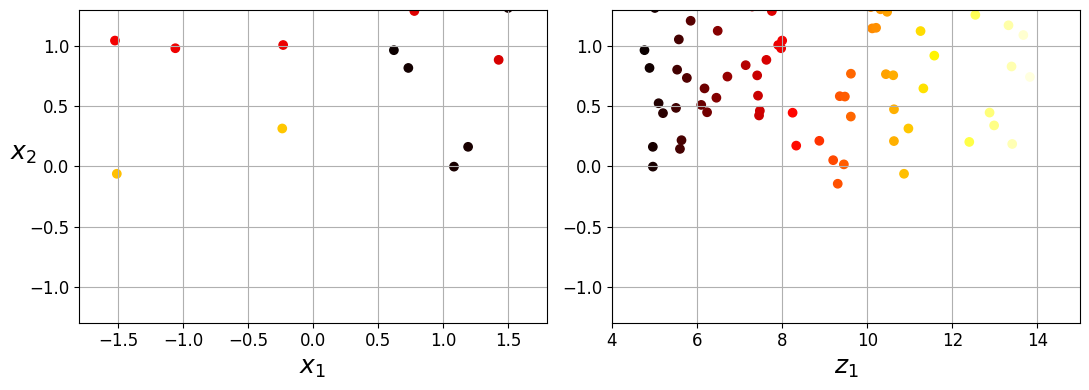

In [39]:
plt.figure(figsize=(11, 4))

plt.subplot(121)    # [왼쪽] 스위스 롤의 x₁–x₂ 평면 투영, 꼬여 있는 구조는 그대로 보임 (정보 손실 O)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)    # [오른쪽] 스위스 롤의 진행도(t) vs 높이(x₂) 시각화, z₁=t 로 가정한 1D 축소 결과처럼 해석 가능 (약간 펼쳐짐)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])   # z₁(t) vs x₂ 범위 설정
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

**Code to generate Figure 8–6. The decision boundary may not always be simpler with lower dimensions:**

Saving figure manifold_decision_boundary_plot1


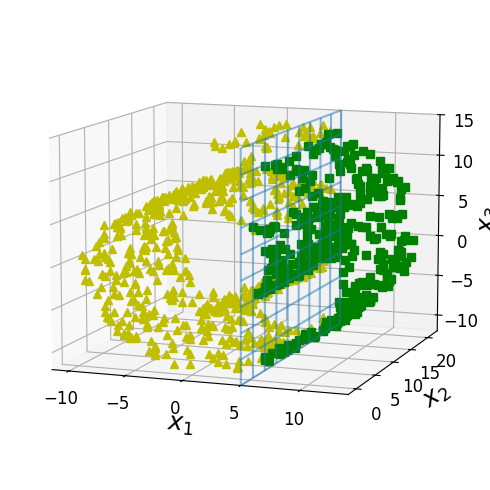

Saving figure manifold_decision_boundary_plot2


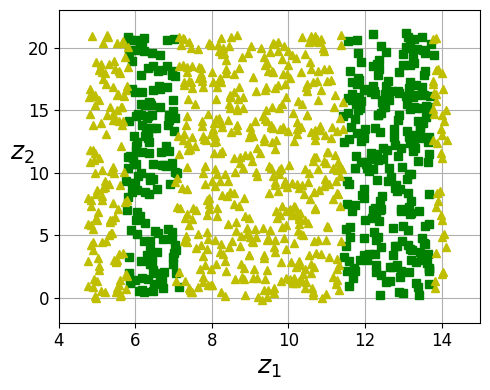

Saving figure manifold_decision_boundary_plot3


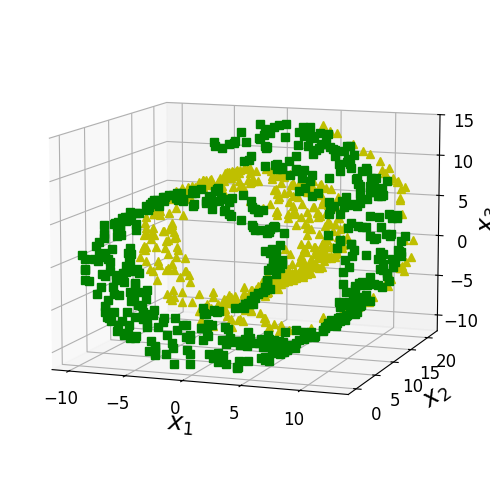

Saving figure manifold_decision_boundary_plot4


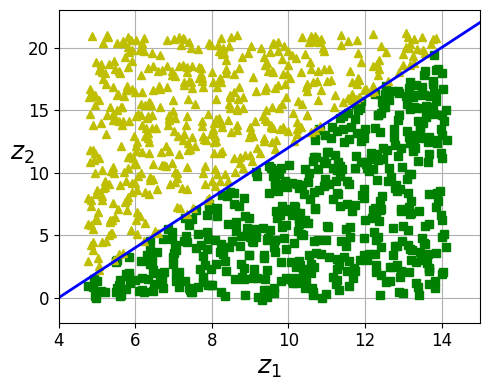

In [40]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

# 결정 경계용 평면 (x₁=5)을 그리기 위한 x₂, x₃ 평면 mesh
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))        # Figure 1: 3D 공간에서 선형 결정 경계 x₁ > 5 를 시각화
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5            # 클래스 분리 기준: x₁ > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)                   # 시점 조정
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")    # 음성 클래스: 노란색 삼각형
ax.plot_wireframe(5, x2, x3, alpha=0.5)                 # 결정 경계 평면 (x₁=5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")    # 양성 클래스: 초록색 사각형
ax.set_xlabel("$x_1$", fontsize=18)                     # 축 및 범위 설정
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))          # Figure 2: Swiss Roll을 납작하게 편 후의 투영 (z₁=t vs x₂)
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")   # 2D 투영 상에서 양성/음성 클래스 표시
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])        # 축 설정
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))          # Figure 3: 비선형 결정 경계 2(t - 4) > x₂ 적용한 3D 시각화
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1] # 클래스 분리 기준: 2(t - 4) > x₂ (비선형 결정 경계)
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)                     # 시점 설정
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")    # 각 클래스 표시
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)       # 축 및 범위 설정
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))          # Figure 4: 비선형 결정 경계가 평평하게 펼쳐진 투영 평면 (z₁ vs x₂)
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")   # 투영된 평면에서 양/음성 클래스 시각화
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)             # 경계선 직접 시각화: z₂ = 2(z₁ - 4)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

**Code to generate Figure 8–7. Selecting the subspace to project on:**

Saving figure pca_best_projection_plot


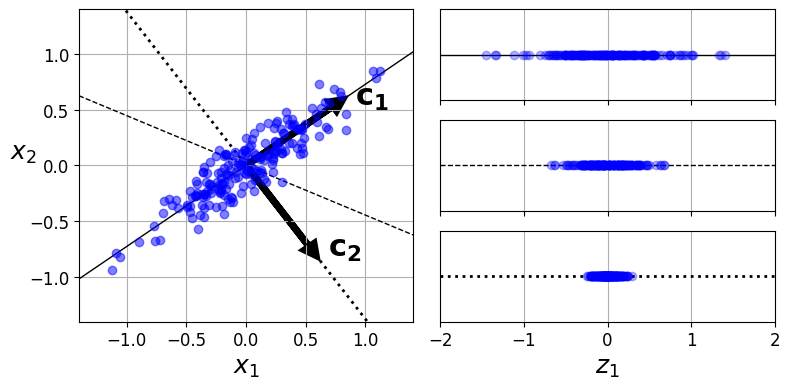

In [41]:
# 데이터 생성: 이차원 정규분포 + 스케일/stretch + 회전

angle = np.pi / 5       # 회전 각도 (~36도)
stretch = 5             # x축 방향으로 늘리기
m = 200                 # 샘플 개수

np.random.seed(3)
X = np.random.randn(m, 2) / 10      # 2D 가우시안 노이즈
X = X.dot(np.array([[stretch, 0],[0, 1]])) # x축으로 stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

# 세 가지 투영 방향 벡터 정의 (각도 기준)
u1 = np.array([np.cos(angle), np.sin(angle)])   # 주 분산 방향 (정답)
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])   # 임의 방향 1
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])   # 임의 방향 2

# 각 방향으로 데이터 투영
X_proj1 = X.dot(u1.reshape(-1, 1))    # 최적 방향
X_proj2 = X.dot(u2.reshape(-1, 1))    # 서브 최적
X_proj3 = X.dot(u3.reshape(-1, 1))    # 최악 방향

plt.figure(figsize=(8,4))             # 시각화 시작

# 왼쪽 큰 그림: 2D 공간과 투영 방향 시각화
plt.subplot2grid((3,2), (0, 0), rowspan=3)

# 각 방향 선형 방정식 (투영선)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)   # 원본 데이터
plt.axis([-1.4, 1.4, -1.4, 1.4])

# 방향 벡터 화살표
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')

# 텍스트 라벨
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))   # 오른쪽 위: 주 분산 방향(u1)으로 투영
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)    # 기준선
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)    # 투영된 점들
plt.gca().get_yaxis().set_ticks([])              # y축 숨김
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))   # 가운데: 중간 방향(u2)으로 투영
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))   # 아래쪽: 비효율 방향(u3)으로 투영
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection_plot")
plt.show()

## Choosing the Right Number of Dimensions

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we set `as_frame=True`.

In [42]:
# MNIST 데이터셋 로드 (70,000개의 28x28 손글씨 이미지, 총 784차원)
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)    # Scikit-Learn 0.24 이상에서는 기본적으로 Pandas DataFrame 반환됨, 책의 예제와 동일하게 numpy 배열을 얻기 위해 as_frame=False 설정
mnist.target = mnist.target.astype(np.uint8)    # 타겟 라벨을 숫자형 정수로 변환 (기본은 문자열로 되어 있음)

In [43]:
from sklearn.model_selection import train_test_split

# 특성(X)과 타겟(y) 추출
X = mnist["data"]   # X: 784개의 픽셀 값 (28x28 이미지 펼친 벡터)
y = mnist["target"] # y: 정답 숫자 라벨 (0~9)

# 학습 데이터와 테스트 데이터로 분할 (기본 비율: 75% / 25%), 랜덤 셔플링 후 분할됨
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [44]:
pca = PCA()       # PCA 객체 생성 (n_components 지정 안함 → 전체 주성분 계산)
pca.fit(X_train)  # 학습 데이터에 대해 주성분 분석 수행
cumsum = np.cumsum(pca.explained_variance_ratio_)   # 각 주성분의 설명된 분산 비율 누적합 계산 → 각 주성분이 전체 데이터 분산을 얼마나 보존하는지 누적합
d = np.argmax(cumsum >= 0.95) + 1   # 누적 설명 분산이 95% 이상 되는 주성분 수 찾기 → 가장 작은 인덱스 d를 찾고 +1 (0부터 시작하므로)

In [45]:
d

np.int64(154)

**Code to generate Figure 8–8. Explained variance as a function of the number of dimensions:**

Saving figure explained_variance_plot


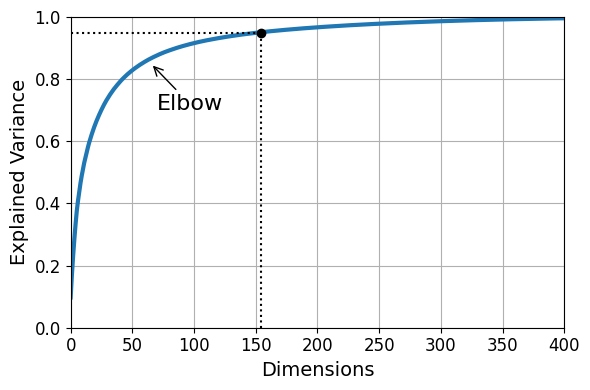

In [46]:
plt.figure(figsize=(6,4))       # 누적 설명 분산 곡선 (Cumulative Explained Variance Plot)
plt.plot(cumsum, linewidth=3)   # PCA 누적 설명 분산 비율
plt.axis([0, 400, 0, 1])        # 축 범위 설정: x축(차원 수), y축(설명된 분산)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

# 95% 기준선 및 수직선 (해당 분산을 만족하는 차원 d)
plt.plot([d, d], [0, 0.95], "k:")     # 수직선
plt.plot([0, d], [0.95, 0.95], "k:")  # 수평선
plt.plot(d, 0.95, "ko")               # 기준점 강조

plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),        # Elbow 주석: 인간이 해석할 수 있는 곡선 꺾임 지점
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [47]:
pca = PCA(n_components=0.95)            # PCA 객체 생성: 누적 설명 분산이 95%가 되도록 주성분 개수 자동 선택 (예: MNIST에서는 약 154개로 줄어들 수 있음)
X_reduced = pca.fit_transform(X_train)  # 학습 데이터를 주성분 공간으로 변환 (차원 축소), 결과: X_reduced는 더 낮은 차원의 표현

In [48]:
pca.n_components_

np.int64(154)

In [49]:
np.sum(pca.explained_variance_ratio_)

np.float64(0.9504334914295707)

## PCA for Compression

In [52]:
pca = PCA(n_components=154)                     # PCA 객체 생성: 주성분 개수 154개로 고정 (95% 분산 보존에 해당)
X_reduced = pca.fit_transform(X_train)          # 차원 축소: 고차원 이미지 데이터를 154차원으로 축소, 결과: X_reduced는 압축된 표현
X_recovered = pca.inverse_transform(X_reduced)  # 복원 (역변환): 축소된 데이터를 원래 784차원 이미지로 되돌림 → 정보 손실이 있음

**Code to generate Figure 8–9. MNIST compression that preserves 95% of the variance:**

In [53]:
# EXTRA
def plot_digits(instances, images_per_row=5, **options):
    size = 28     # MNIST 이미지 크기 (28x28)
    images_per_row = min(len(instances), images_per_row)      # 한 줄에 표시할 이미지 수 제한 (너무 많으면 줄이 바뀌도록)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1       # 필요한 행의 개수 계산

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)        # 이미지 개수가 모자랄 경우, 빈 이미지(0)로 채워서 그리드 맞추기
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))   # 각 이미지를 (n_rows, images_per_row, 28, 28) 형태로 reshape

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,           # 축 rearrange → 전체 big_image 만들기
                                                         images_per_row * size)   # transpose로 축 순서 맞추고, 이어 붙여서 (height, width) 이미지 구성
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


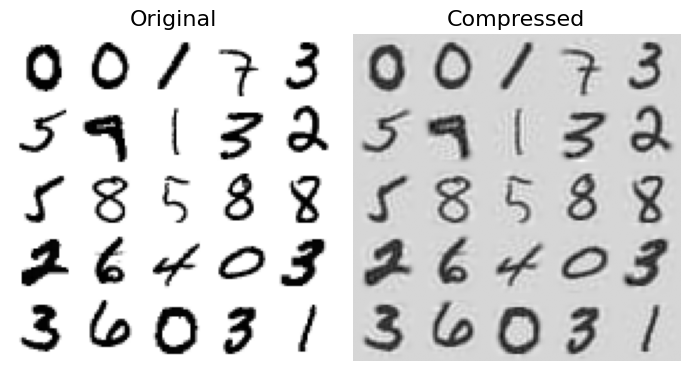

In [54]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [55]:
X_reduced_pca = X_reduced

## Randomized PCA

In [56]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Incremental PCA

In [58]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [59]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

Let's check that compression still works well:

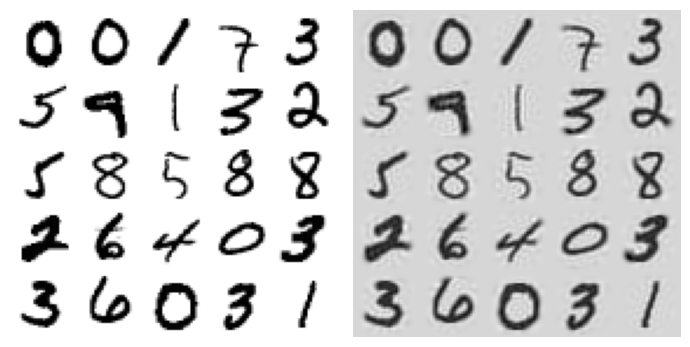

In [60]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [61]:
X_reduced_inc_pca = X_reduced

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal:

In [62]:
np.allclose(pca.mean_, inc_pca.mean_)

True

But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect:

In [63]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

**Using `memmap()`:**

Let's create the `memmap()` structure and copy the MNIST data into it. This would typically be done by a first program:

In [65]:
filename = "my_mnist.data"    # 저장할 파일 이름
m, n = X_train.shape          # m: 샘플 수, n: 차원 수 (예: 52500, 784)

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train             # 실제 데이터를 메모리 맵 파일에 복사, 디스크에 저장되며, flush() 없이도 기본적으로 안전하게 기록됨

Now deleting the `memmap()` object will trigger its Python finalizer, which ensures that the data is saved to disk.

In [66]:
del X_mm

Next, another program would load the data and use it for training:

In [67]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))      # 메모리맵된 대용량 데이터 불러오기 (읽기 전용)

batch_size = m // n_batches                                                     # 배치 크기 계산: 전체 데이터를 n_batches 개의 배치로 나눔
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)               # Incremental PCA 객체 생성 - n_components=154: 95% 분산을 보존하는 주성분 개수 - batch_size: 한 번에 처리할 샘플 수 (메모리 최적화용)
inc_pca.fit(X_mm)                                                               # 점진적 학습 (메모리맵 배열 전체를 배치 단위로 처리)
                                                                                # - 내부적으로 partial_fit()이 여러 번 호출됨
                                                                                # - 매우 큰 데이터도 처리 가능

IncrementalPCA(batch_size=525, n_components=154)

**Time complexity:**

Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [68]:
import time

# 테스트할 주성분 개수들: 아주 작게 (2), 작게 (10), 실제 목적 수준 (154)
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")                           # (1) 일반 PCA (full SVD 기반)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)                       # (2) 점진적 PCA (Incremental PCA) - 배치 기반 학습
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")        # (3) 랜덤화 PCA (Randomized SVD 기반) - 빠르지만 근사

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):      # 각 PCA 기법에 대해 학습 시간 측정 및 출력
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

n_components = 2
    PCA: 22.0 seconds
    Inc PCA: 53.7 seconds
    Rnd PCA: 2.6 seconds
n_components = 10
    PCA: 27.8 seconds
    Inc PCA: 64.7 seconds
    Rnd PCA: 5.9 seconds
n_components = 154
    PCA: 16.9 seconds
    Inc PCA: 82.9 seconds
    Rnd PCA: 12.3 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

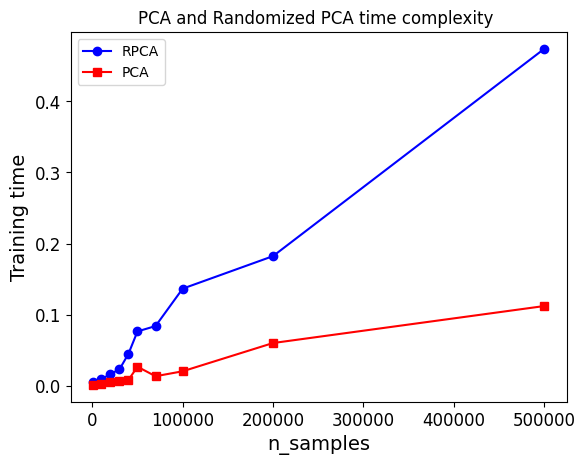

In [69]:
# PCA 학습 시간 저장용 리스트 초기화
times_rpca = []   # Randomized PCA (RPCA)
times_pca = []    # 정규(full) PCA
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]      # 테스트할 샘플 수 목록

# 각 샘플 크기에 대해 PCA와 RPCA의 fit() 시간 비교
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)                                           # 무작위 데이터 생성: (n_samples, 5차원) → 고정 차원
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")                                # 일반 PCA (정확한 full SVD)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

# 학습 시간 비교 시각화
plt.plot(sizes, times_rpca, "b-o", label="RPCA")                                # 파란색 원 - Randomized PCA
plt.plot(sizes, times_pca, "r-s", label="PCA")                                  # 빨간색 사각형 - 일반 PCA
plt.xlabel("n_samples")                                                         # x축: 샘플 수
plt.ylabel("Training time")                                                     # y축: 학습 시간 (초)
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

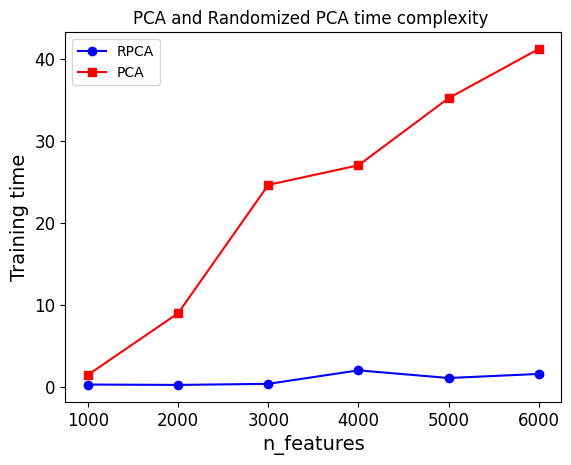

In [70]:
# 학습 시간 기록 리스트 초기화
times_rpca = []                                   # Randomized PCA 시간
times_pca = []                                    # 일반 PCA 시간
sizes = [1000, 2000, 3000, 4000, 5000, 6000]      # 테스트할 특성(feature) 수 목록

# 각 feature 수에 대해 PCA 및 Randomized PCA 학습 시간 측정
for n_features in sizes:
    X = np.random.randn(2000, n_features)         # (2000개 샘플, n_features 특성) 무작위 데이터 생성
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")         # Randomized PCA: 근사 SVD로 속도 빠름
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")                                # 일반 PCA: 정확한 full SVD 방식
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

In [71]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)  # 비선형 데이터셋 생성: Swiss Roll (3D 나선형 곡면)

In [72]:
from sklearn.decomposition import KernelPCA

# 커널 PCA 적용 (비선형 차원 축소)
# - kernel="rbf": 가우시안(RBF) 커널 사용
# - gamma=0.04: 커널 폭 조절 (작을수록 더 부드럽게 펼쳐짐)
# - n_components=2: 2차원으로 펼치기
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)       # 비선형 차원 축소 결과

**Code to generate Figure 8–10. Swiss roll reduced to 2D using kPCA with various kernels:**

Saving figure kernel_pca_plot


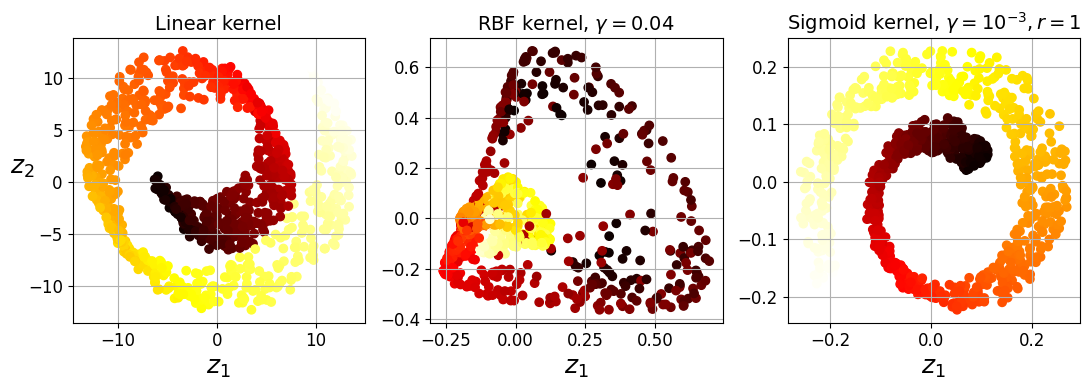

In [73]:
from sklearn.decomposition import KernelPCA

# Kernel PCA 객체 정의 (모두 2차원 축소, 역변환 허용)
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)                          # 선형 커널 (일반 PCA와 유사)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)               # RBF 커널
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)   # 시그모이드 커널

# 이진 분류 시각화용 타겟 생성: t 값 기준으로 분할
y = t > 6.9     # (불리언 마스크) t가 큰 쪽과 작은 쪽 나눔

plt.figure(figsize=(11, 4))       # 시각화: 각 커널 PCA로 축소한 결과를 2D로 플롯
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:            # RBF 결과 따로 저장 (추후 inverse_transform 등에 활용 가능)
        X_reduced_rbf = X_reduced

    # 연속 값 t를 색상으로 지정
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")     # 원래는 이진 분류 마커로도 그릴 수 있음
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

**Code to generate Figure 8–11. Kernel PCA and the reconstruction pre-image error:**

Saving figure preimage_plot


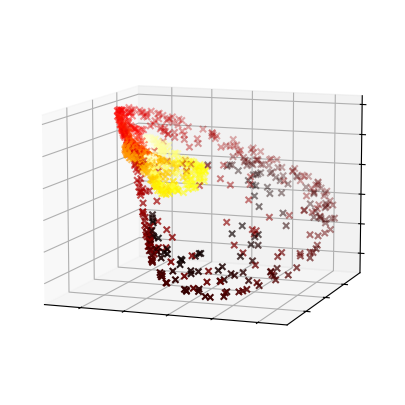

In [74]:
plt.figure(figsize=(6, 5))

# RBF 커널 PCA 결과를 원래 3D 공간으로 복원 (approximate inverse)
# - X_reduced_rbf는 2차원으로 축소된 표현
# - inverse_transform()으로 근사 복원
X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')    # 3D 플롯 준비
ax.view_init(10, -70)                     # 시점 조정 (elevation, azimuth)

# 복원된 점들 시각화 (색상은 원래 매니폴드 파라미터 t 기반), marker='x'로 복원된 점들 강조
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

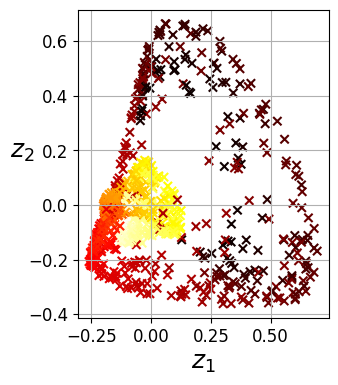

In [76]:
# RBF 커널 PCA 적용: 3D 데이터를 2D로 차원 축소, 결과는 비선형 구조를 평면에 잘 펼쳐낸 표현
X_reduced = rbf_pca.fit_transform(X)

# 2차원 차원축소 결과 시각화 (컬러는 원래 위치 t 기반)
plt.figure(figsize=(11, 4))       # 가로 길쭉한 플롯
plt.subplot(132)                  # 가운데 서브플롯 (1행 3열 중 2번째)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")   # 축소된 좌표를 색깔(t 값)로 표현
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

## Selecting a Kernel and Tuning Hyperparameters

In [77]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 전체 분류 파이프라인 정의
# - Step 1: Kernel PCA (비선형 차원 축소)
# - Step 2: 로지스틱 회귀 (선형 분류기)
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),              # 축소: 2차원
        ("log_reg", LogisticRegression(solver="lbfgs"))   # 분류기
    ])

# 하이퍼파라미터 탐색 공간 정의
# - gamma: 커널 폭 (0.03 ~ 0.05 사이 10개 값)
# - kernel: "rbf" vs "sigmoid" 비교
# - "kpca__" prefix는 파이프라인 명 지정
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),       # 10단계 gamma
        "kpca__kernel": ["rbf", "sigmoid"]                # 커널 종류
    }]

# GridSearchCV로 최적 커널 및 gamma 탐색
# - 3겹 교차 검증 (cv=3)
# - 총 10 x 2 = 20개 조합 평가
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)                                     # Swiss Roll 분류 타깃(y: t > 6.9)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [ ]:
print(grid_search.best_params_)   # 최적의 하이퍼파라미터 조합

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [ ]:
# RBF 커널 PCA 적용 (2차원 축소 + 복원 지원)
# - gamma=0.0433: 적절한 비선형성
# - fit_inverse_transform=True: inverse_transform() 가능
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)                # 2차원으로 축소
X_preimage = rbf_pca.inverse_transform(X_reduced)   # 다시 3차원 원래 공간으로 복원

In [ ]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)               # 복원된 데이터와 원본 데이터 간의 평균 제곱 오차 (MSE) 계산 → 작을수록 복원이 잘 됨

1.4326103121600706e-26

# LLE

In [80]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)    # Swiss Roll 데이터셋 생성 (3D의 비선형 구조, 매니폴드), noise=0.2: 관측 오차

In [81]:
# Locally Linear Embedding (LLE) 설정
# - n_components=2: 2차원으로 축소
# - n_neighbors=10: 각 포인트가 참조할 이웃 수
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)    # LLE를 사용한 차원 축소 수행, 비선형 구조를 평면에 펼치는 데 탁월함

**Code to generate Figure 8–12. Unrolled Swiss roll using LLE:**

Saving figure lle_unrolling_plot


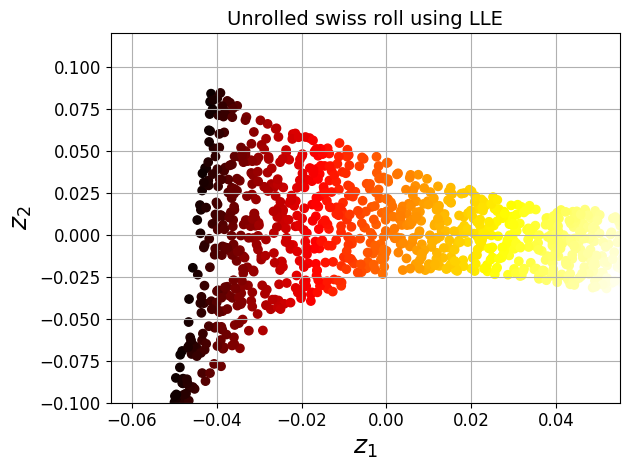

In [82]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)   # LLE로 축소된 2D 좌표 시각화 (색상은 원래 위치 t 기준) - cmap=plt.cm.hot: 색상이 위치를 나타냄
plt.xlabel("$z_1$", fontsize=18)        # 축 라벨 및 시각 설정
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])   # 좌표 축 범위 고정 (원하는 영역 강조)
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## Other Dimensionality Reduction Techniques

In [83]:
from sklearn.manifold import MDS

# MDS (Multidimensional Scaling) 객체 생성, n_components=2: 2차원으로 축소
mds = MDS(n_components=2, random_state=42)

# MDS를 사용해 고차원 데이터를 2차원으로 축소
# - 입력: X (예: Swiss Roll, 3D)
# - 출력: X_reduced_mds (2D 평면상의 좌표)
# - 목적: 원래 거리 구조를 최대한 보존하는 임베딩 찾기
X_reduced_mds = mds.fit_transform(X)

In [84]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)               # Isomap: 거리 기반 비선형 차원 축소 (LLE의 확장)
X_reduced_isomap = isomap.fit_transform(X)    # 예: Swiss Roll 등 매니폴드 데이터에 적합

In [85]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)  # t-SNE: 지역적인 거리 구조를 잘 보존하는 비선형 임베딩
X_reduced_tsne = tsne.fit_transform(X)        # 클러스터 또는 계층 구조 시각화에 탁월

In [86]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)                         # 클래스 간 분산을 극대화하는 선형 투영 학습
X_reduced_lda = lda.transform(X_mnist)            # 차원 축소 수행 (예: 154차원 → 2차원)

**Code to generate Figure 8–13. Using various techniques to reduce the Swill roll to 2D:**

Saving figure other_dim_reduction_plot


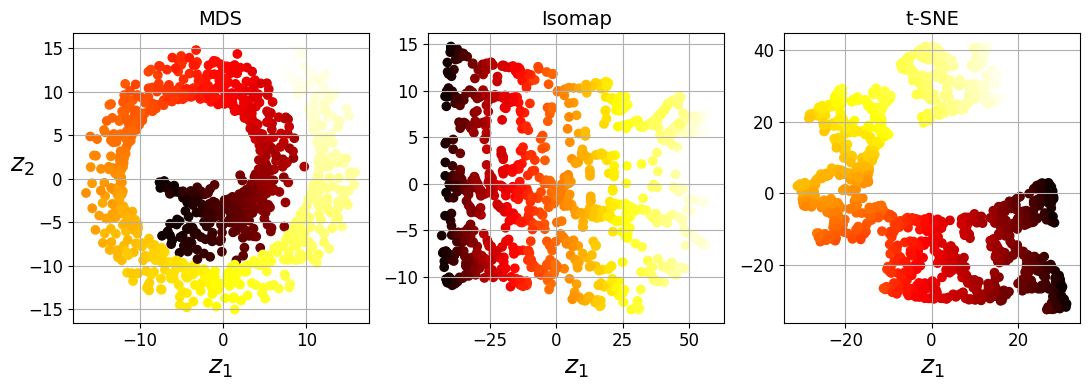

In [87]:
titles = ["MDS", "Isomap", "t-SNE"] # 각 subplot 제목

plt.figure(figsize=(11,4))  # 가로로 긴 figure 생성 (1행 3열)

for subplot, title, X_reduced in zip((131, 132, 133), titles,     # 각 차원 축소 기법별 시각화, subplot 131: MDS, 132: Isomap, 133: t-SNE
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):  # 임베딩 결과
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)          # 각 기법으로 축소된 2D 좌표 시각화 (색상은 원래 t 값 기준)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# Exercise solutions

## 1. to 8.

See appendix A.

## 9.

*Exercise: Load the MNIST dataset (introduced in chapter 3) and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).*

The MNIST dataset was loaded earlier.

In [ ]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*Exercise: Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set.*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 35.27s


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

*Exercise: Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%.*

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*Exercise: Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?*

In [ ]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 81.03s


Oh no! Training is actually more than twice slower now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm. See figure 8-6 (the `manifold_decision_boundary_plot*` plots above). If you try a softmax classifier instead of a random forest classifier, you will find that training time is reduced by a factor of 3 when using PCA. Actually, we will do this in a second, but first let's check the precision of the new random forest classifier.

*Exercise: Next evaluate the classifier on the test set: how does it compare to the previous classifier?*

In [ ]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance. :(

Let's see if it helps when using softmax regression:

In [ ]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 18.39s


In [ ]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

Okay, so softmax regression takes much longer to train on this dataset than the random forest classifier, plus it performs worse on the test set. But that's not what we are interested in right now, we want to see how much PCA can help softmax regression. Let's train the softmax regression model using the reduced dataset:

In [ ]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/Users/ageron/miniconda3/envs/tf2/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
print("Training took {:.2f}s".format(t1 - t0))

Training took 6.94s


Nice! Reducing dimensionality led to over 2× speedup. :)  Let's check the model's accuracy:

In [ ]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

A very slight drop in performance, which might be a reasonable price to pay for a 2× speedup, depending on the application.

So there you have it: PCA can give you a formidable speedup... but not always!

## 10.

*Exercise: Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.*

The MNIST dataset was loaded above.

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [ ]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

Now let's use t-SNE to reduce dimensionality down to 2D so we can plot the dataset:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

Now let's use Matplotlib's `scatter()` function to plot a scatterplot, using a different color for each digit:

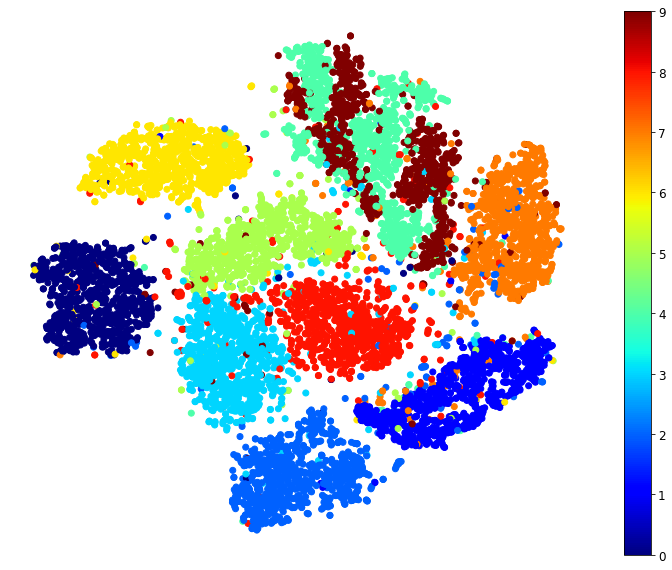

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Isn't this just beautiful? :) This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 2, 3 and 5, which seem to overlap a lot.

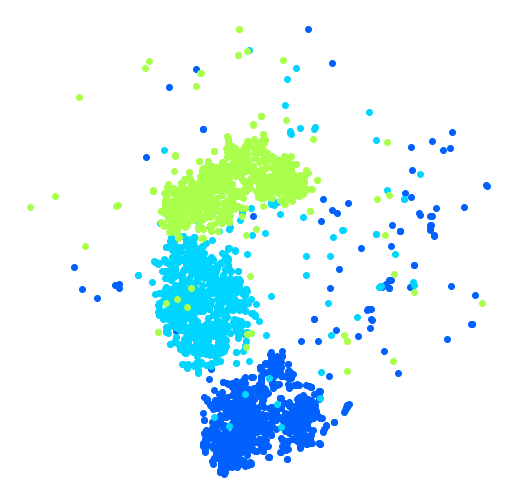

In [ ]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [ ]:
idx = (y == 2) | (y == 3) | (y == 5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

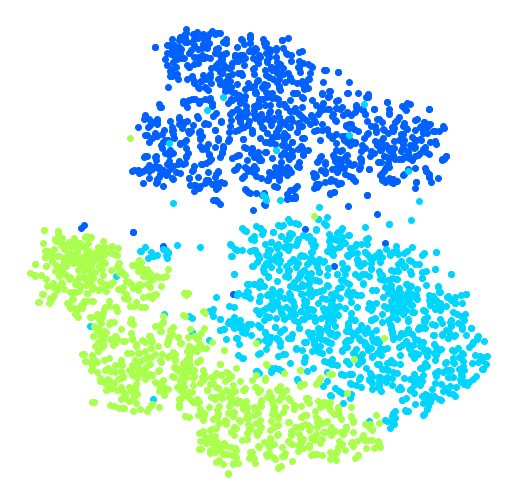

In [ ]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now.

*Exercise: Alternatively, you can write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits.*

Let's create a `plot_digits()` function that will draw a scatterplot (similar to the above scatterplots) plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead. This implementation was inspired from one of Scikit-Learn's excellent examples ([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), based on a different digit dataset).

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

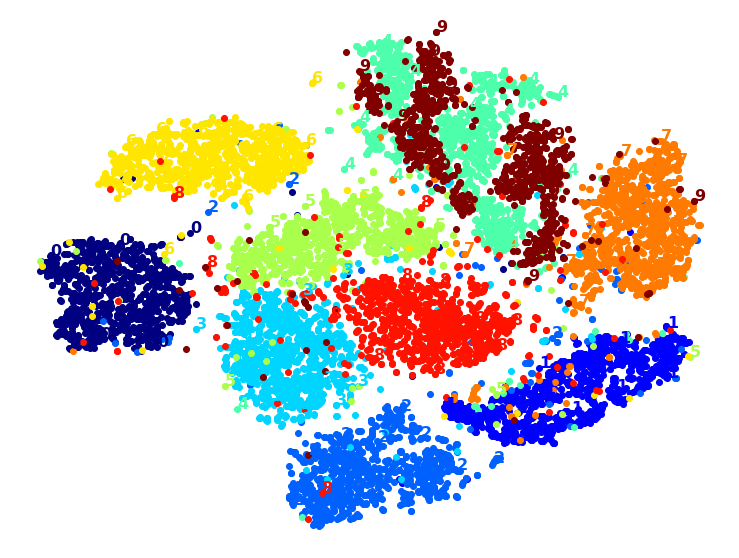

In [ ]:
plot_digits(X_reduced, y)

Well that's okay, but not that beautiful. Let's try with the digit images:

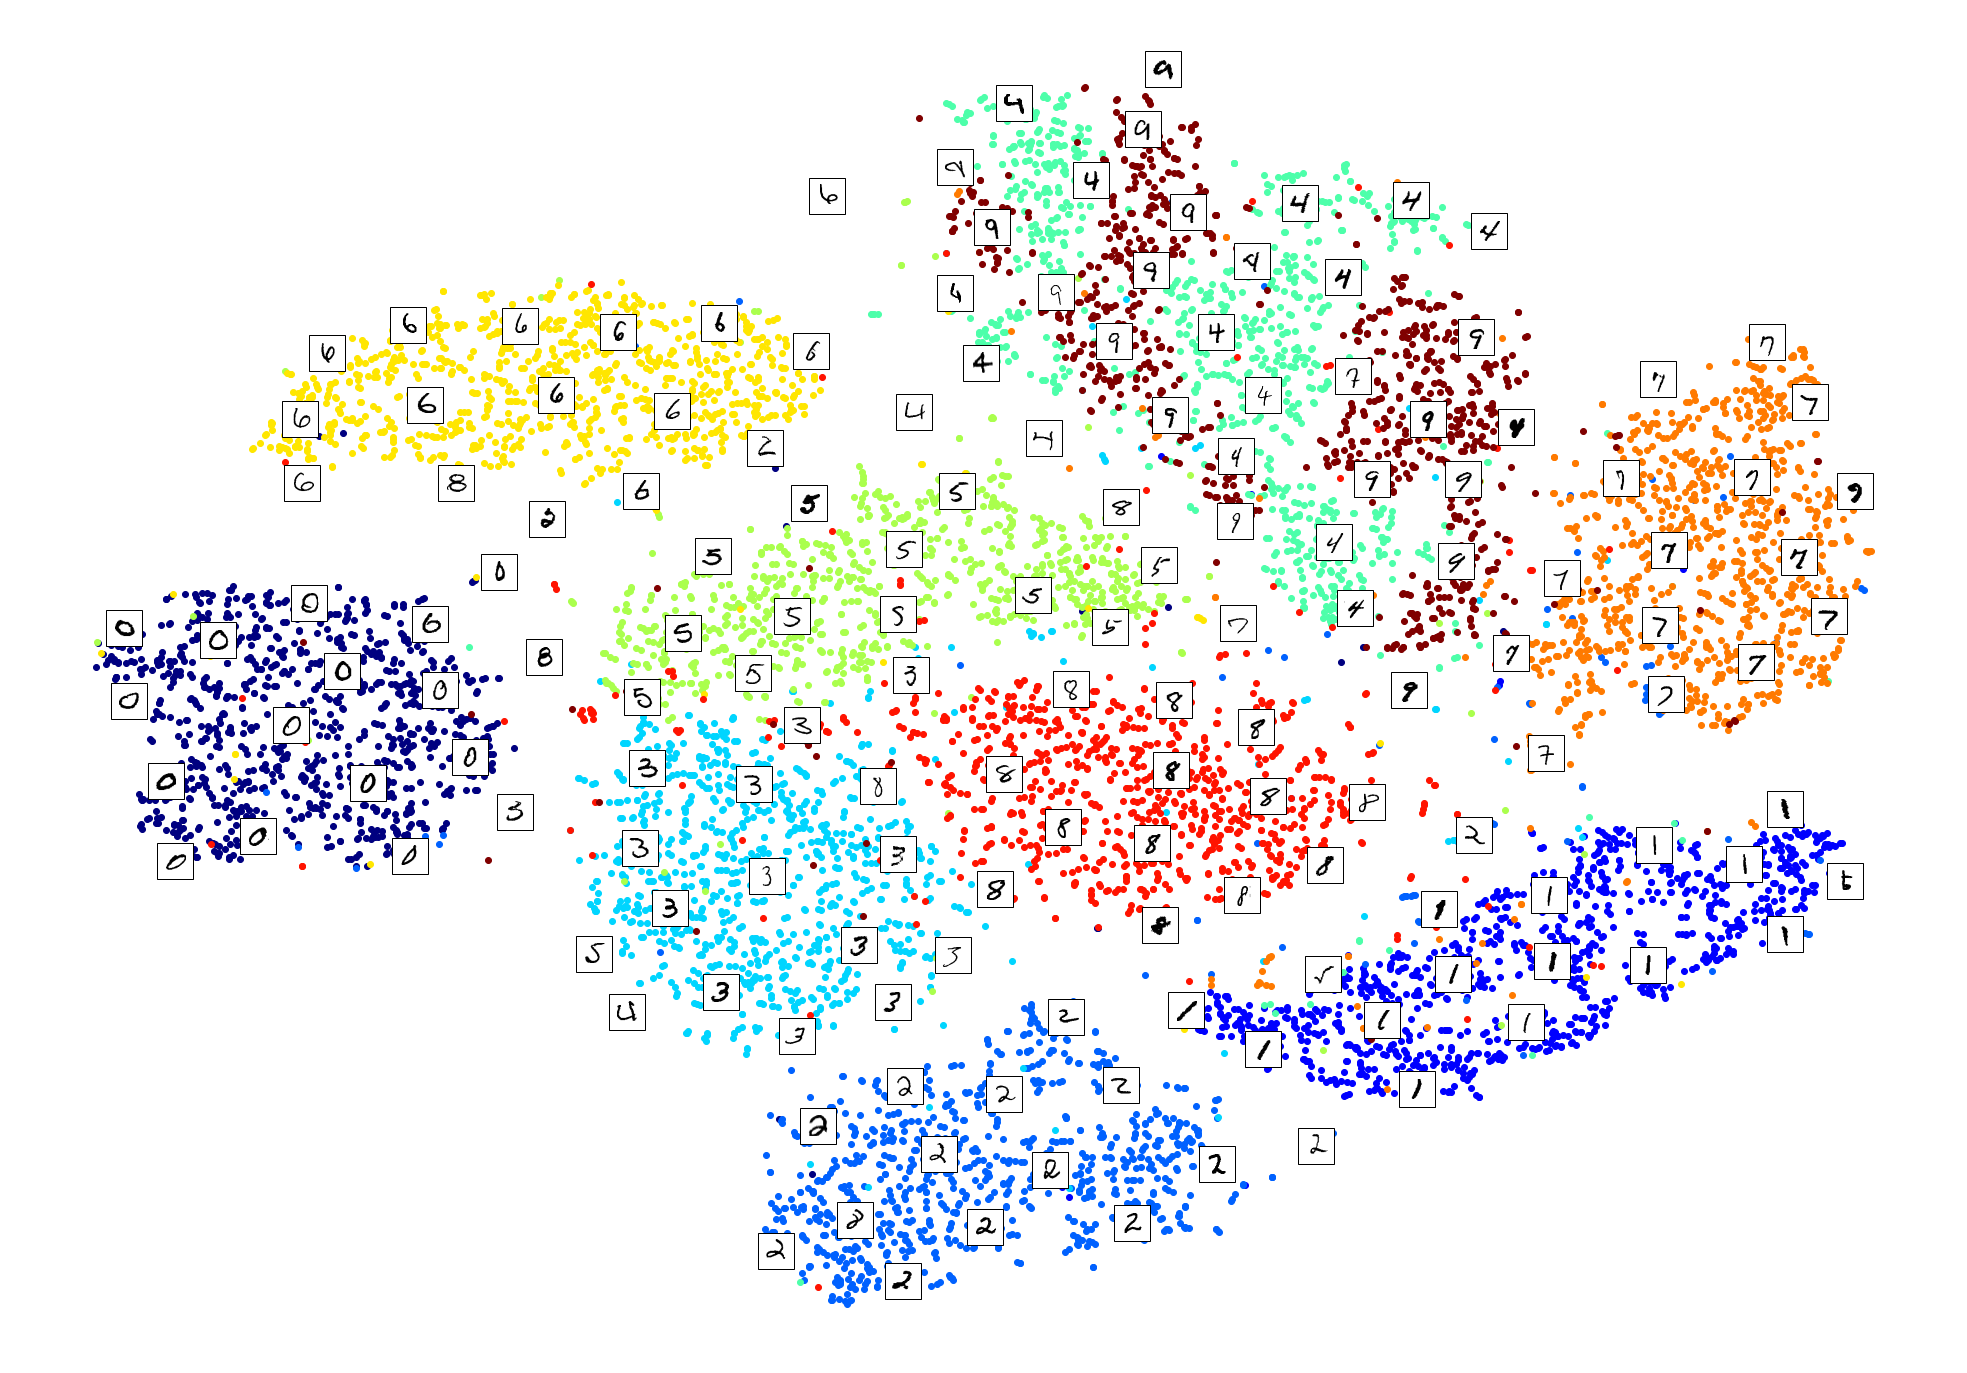

In [ ]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

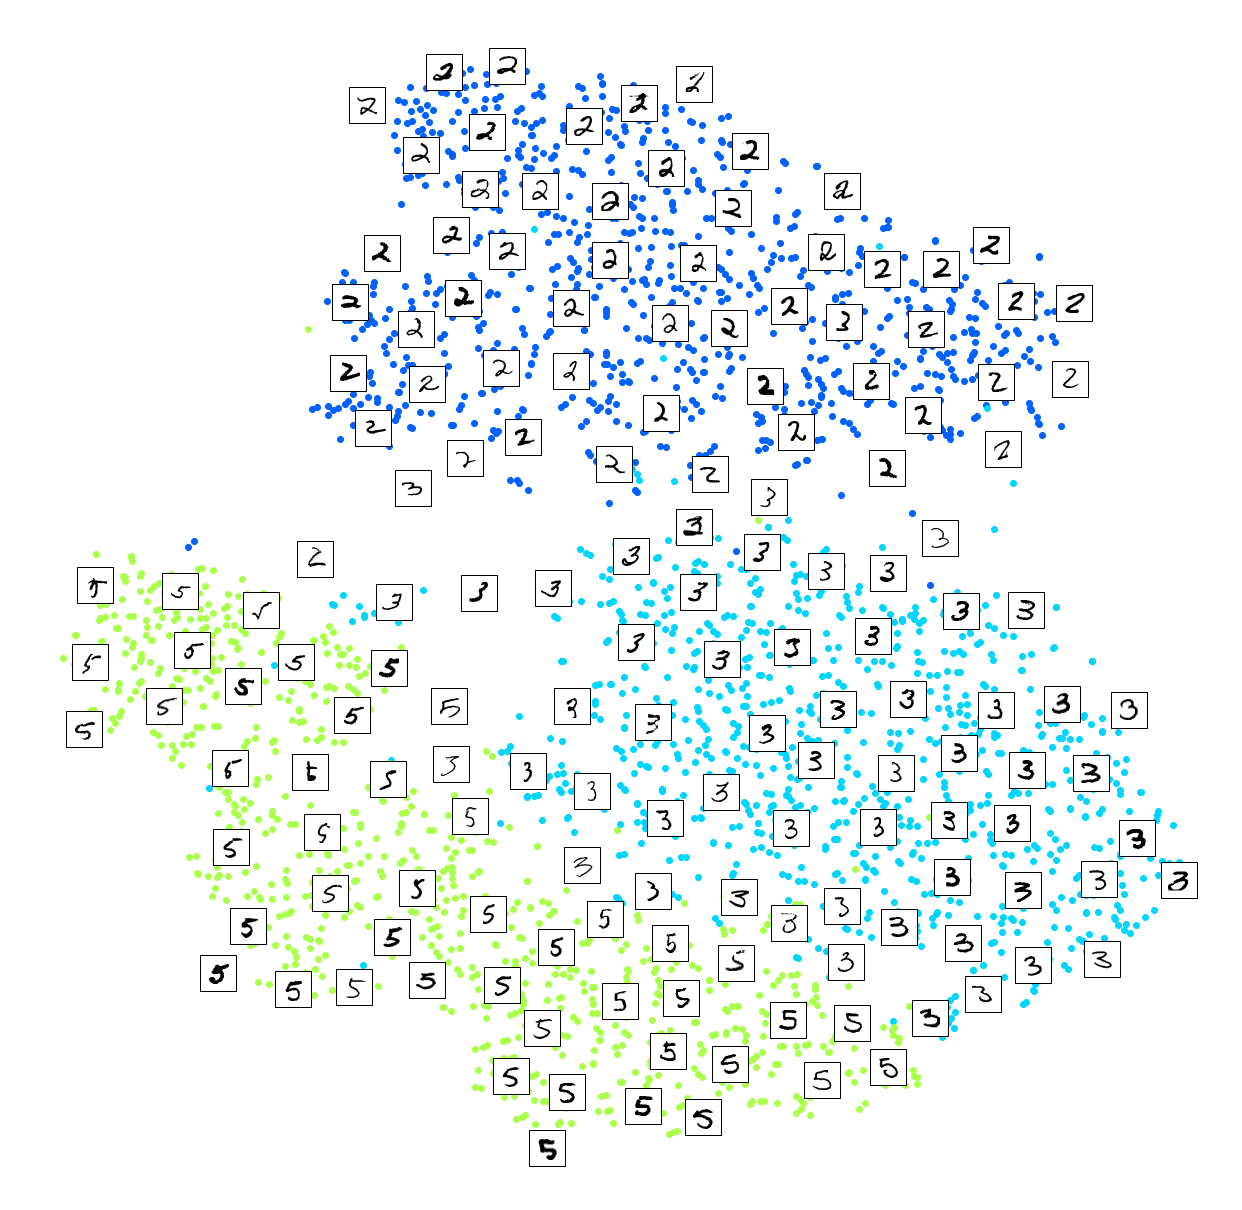

In [ ]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*Exercise: Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations.*

Let's start with PCA. We will also time how long it takes:

PCA took 0.2s.


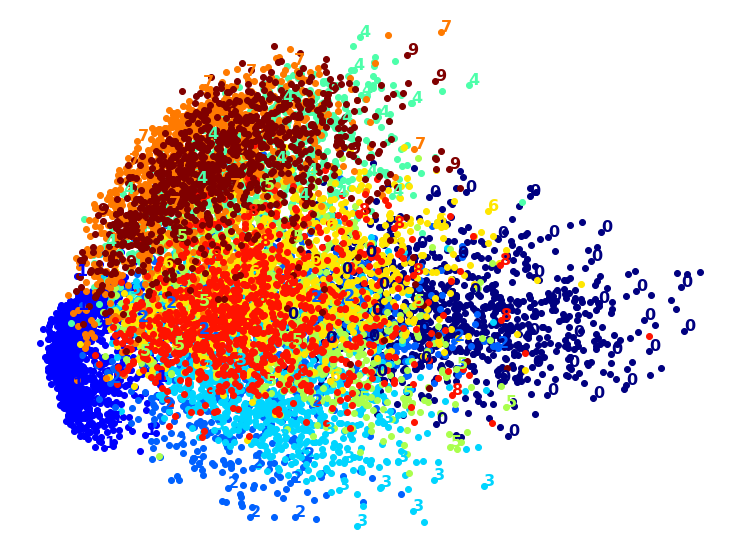

In [ ]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

Wow, PCA is blazingly fast! But although we do see a few clusters, there's way too much overlap. Let's try LLE:

LLE took 131.9s.


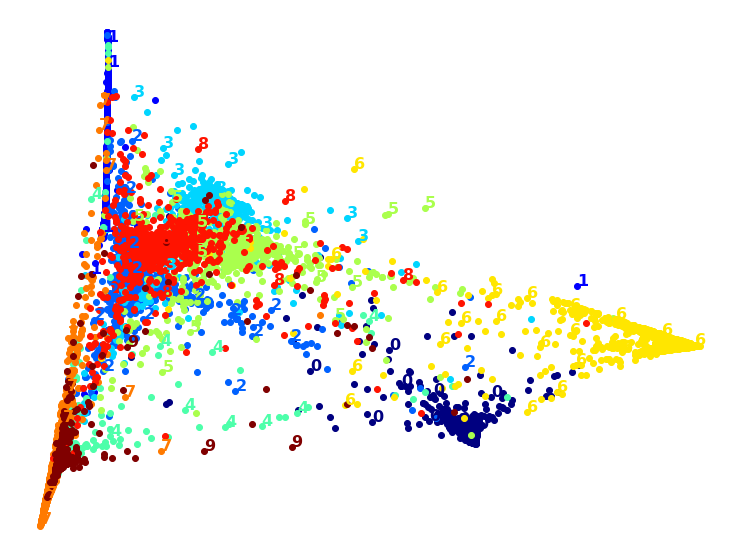

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 34.9s.


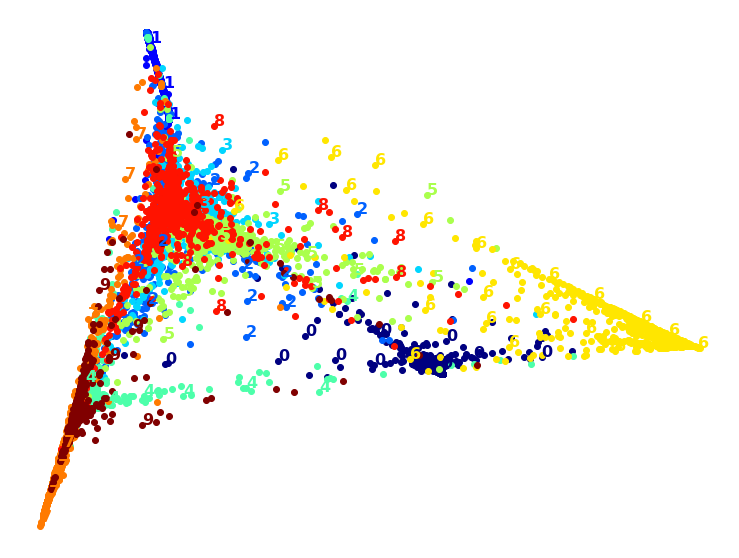

In [ ]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

MDS took 95.7s (on just 2,000 MNIST images instead of 10,000).


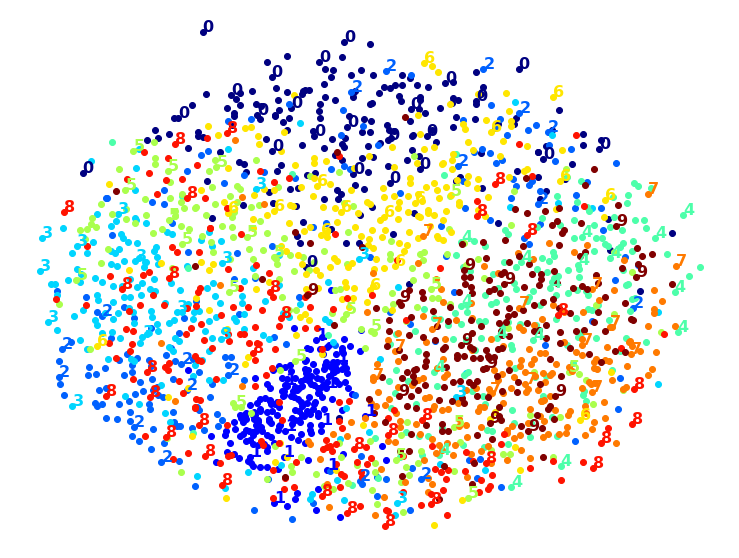

In [ ]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

Meh. This does not look great, all clusters overlap too much. Let's try with PCA first, perhaps it will be faster?

PCA+MDS took 95.2s (on 2,000 MNIST images).


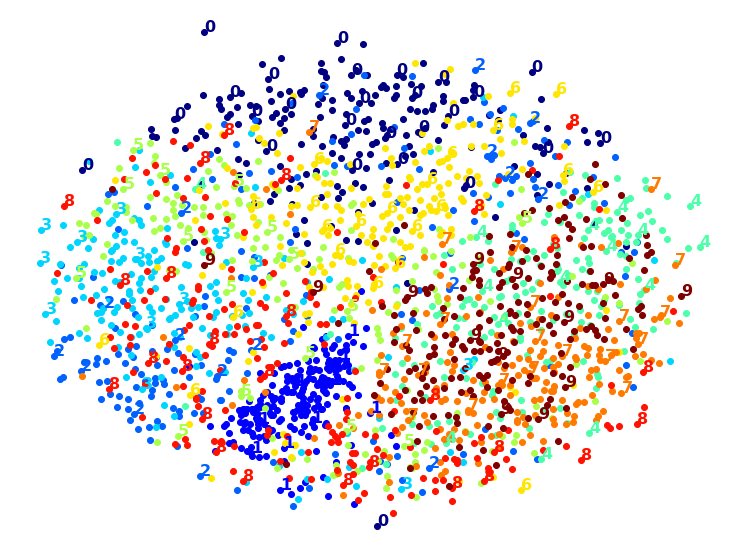

In [ ]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

Same result, and no speedup: PCA did not help (or hurt).

Let's try LDA:

LDA took 1.3s.


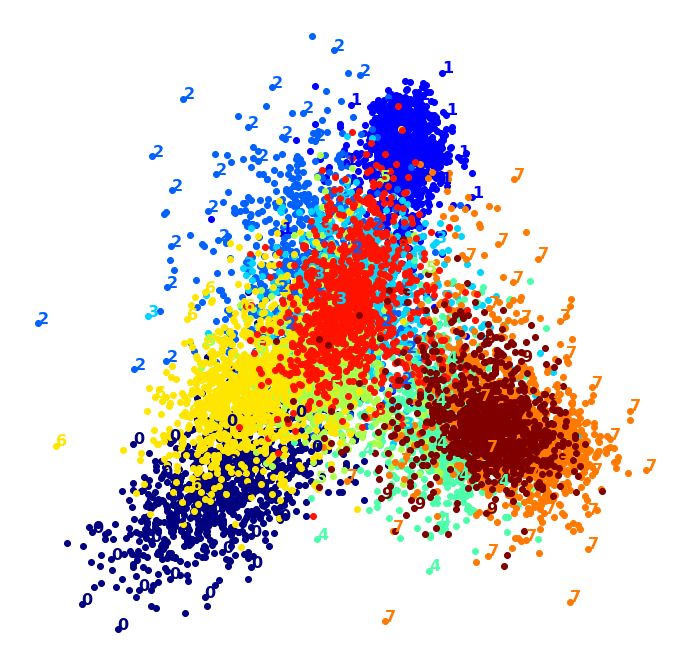

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, wouldn't you agree? We did not time it, so let's do that now:

t-SNE took 157.3s.


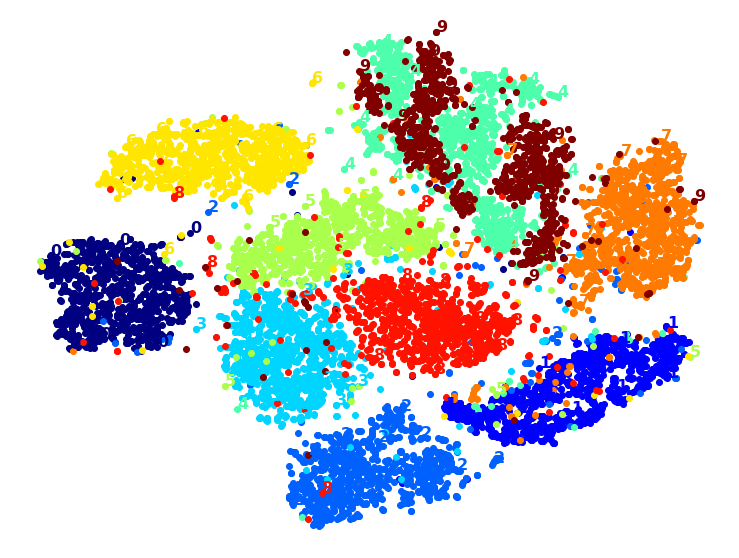

In [ ]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

It's twice slower than LLE, but still much faster than MDS, and the result looks great. Let's see if a bit of PCA can speed it up:

PCA+t-SNE took 62.0s.


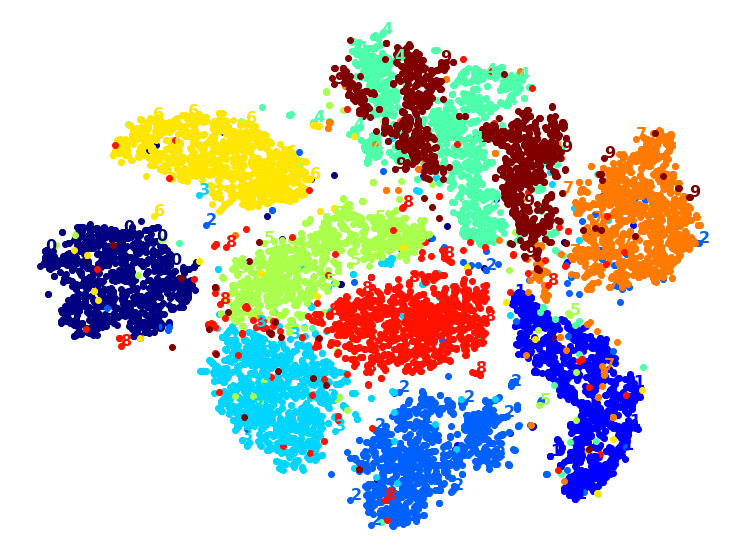

In [ ]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us over 2x speedup, without damaging the result. We have a winner!